#### Jeromey Schwartz
#### HW3
#### SID: 801055747
#### https://github.com/JS-CTRL/RealTimeAI/tree/main/HW3


### Problem 1: CIFAR 10 CNN

In [1]:
#Importing libraries
%matplotlib inline
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
import datetime
import numpy as np
import collections
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from ptflops import get_model_complexity_info

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
#defining 10 classes 
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [3]:
#loading training data
data_path = '/data'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))
cifar10

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))
           )

In [4]:
#loading validation data
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))
cifar10_val

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))
           )

In [5]:
#set number of epochs to train for all models
num_epochs=150

#array to hold max validation value for each model
max_accuracy_comparison=np.zeros(6)

#dict to hold final(epoch 300) accuracies across different models
all_acc_dict = collections.OrderedDict()

#dict to hold mac/param count for each model
param_count_dict=collections.OrderedDict()

#loading data loader for batching(shuffel off to allow repeatability)
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=16, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=16, shuffle=False)

#load data onto GPU if available
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [6]:
#Set up to show how long each epoch takes, both training and validation
def validate(model, train_loader, val_loader,print_output=False):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        if print_output == True:
            print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

In [7]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader,val_loader,acc_dict):
    start_time=datetime.datetime.now()
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device) 
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                    datetime.datetime.now()-start_time, epoch,
                    loss_train / len(train_loader)))
        acc_dict[epoch] = validate(model, train_loader, val_loader)

In [8]:
def get_model_info(model_in):
    param_dict={}
    with torch.cuda.device(0):
        net = model_in
        macs, params = get_model_complexity_info(net, (3, 224, 224), as_strings=True,
                                               print_per_layer_stat=True, verbose=True)
        print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
        print('{:<30}  {:<8}'.format('Number of parameters: ', params))
      
        
        param_dict['Params']=params
        param_dict['macs']=macs
    return param_dict

#### Part A

In [9]:
#Defining the model
class NetA(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 4)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [10]:
#Running the model
NetA_Acc=collections.OrderedDict()
model = NetA().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = num_epochs,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader,
    acc_dict=NetA_Acc
)
all_acc_dict['CNN_A'] = validate(model, train_loader, val_loader, print_output=True)

0:00:19.681903 Epoch 1, Training loss 2.1605649863815306
0:04:47.989971 Epoch 10, Training loss 1.455136698589325
0:09:47.290230 Epoch 20, Training loss 1.2936052706336976
0:14:48.255003 Epoch 30, Training loss 1.1938993736839294
0:19:49.454990 Epoch 40, Training loss 1.1284097987270356
0:24:49.333783 Epoch 50, Training loss 1.0831460089588165
0:29:48.470894 Epoch 60, Training loss 1.0489709366321565
0:34:53.135537 Epoch 70, Training loss 1.0206624280548096
0:39:57.324927 Epoch 80, Training loss 0.9952706547546387
0:44:59.808797 Epoch 90, Training loss 0.9735998730182648
0:50:10.337825 Epoch 100, Training loss 0.9542308826065063
0:55:19.503612 Epoch 110, Training loss 0.9367282503795624
1:00:27.582157 Epoch 120, Training loss 0.9210166981315613
1:05:41.041921 Epoch 130, Training loss 0.9068104931163787
1:10:56.388658 Epoch 140, Training loss 0.8940298349857331
1:16:06.543376 Epoch 150, Training loss 0.8824672892856598
Accuracy train: 0.70
Accuracy val: 0.64


In [11]:
#Model size/Complexity
param_count_dict['CNN_A']=get_model_info(model)

NetA(
  0.017 M, 100.000% Params, 0.012 GMac, 100.000% MACs, 
  (conv1): Conv2d(0.0 M, 1.320% Params, 0.011 GMac, 93.212% MACs, 3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(0.016 M, 96.735% Params, 0.001 GMac, 6.658% MACs, in_features=512, out_features=32, bias=True)
  (fc2): Linear(0.0 M, 1.945% Params, 0.0 GMac, 0.130% MACs, in_features=32, out_features=10, bias=True)
)
Computational complexity:       0.01 GMac
Number of parameters:           16.97 k 


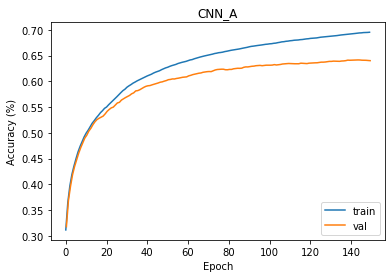

In [12]:
#Plotting training and validation accuracy vs epoch
trn_acc = [v['train'] for k, v in NetA_Acc.items()]
val_acc = [v['val'] for k, v in NetA_Acc.items()]

width =0.3
plt.title(Title_Name)
plt.plot(np.arange(len(trn_acc)), trn_acc,  label='train')
plt.plot(np.arange(len(val_acc))+ width, val_acc,  label='val')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.savefig('Graphs/CNN_A_Accuracy_150.png', bbox_inches='tight')
plt.show()

In [13]:
#Finding max validation accuracy and its epoch
NetA_max_val=0
NetA_max_val_epoch=0
tmp=0
for i in range(num_epochs):
    tmp=NetA_Acc[i+1]['val']
    if (tmp > NetA_max_val):
        NetA_max_val=tmp
        NetA_max_val_epoch=i+1
max_accuracy_comparison[0]=NetA_max_val
print('Max validation value for CNN_A is',NetA_max_val,'on epoch',NetA_max_val_epoch)

Max validation value for CNN_A is 0.6418 on epoch 143


#### Part B

In [14]:
#Defining the model
class NetB(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8) # <1>
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [15]:
#Running the model
NetB_Acc=collections.OrderedDict()
model = NetB().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = num_epochs,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader,
    acc_dict=NetB_Acc
)
all_acc_dict["CNN_B"] = validate(model, train_loader, val_loader, print_output=True)
#torch.save(model.state_dict(), 'batch_1000_epoch_300.pt')

0:00:16.847333 Epoch 1, Training loss 2.1595796466445925
0:05:10.257500 Epoch 10, Training loss 1.4981561505889893
0:10:31.145018 Epoch 20, Training loss 1.2843281418037416
0:15:56.123907 Epoch 30, Training loss 1.1450551690864563
0:21:18.918738 Epoch 40, Training loss 1.0630111858558655
0:26:42.553830 Epoch 50, Training loss 1.0022866076850891
0:32:10.385763 Epoch 60, Training loss 0.9465530207824707
0:37:43.852807 Epoch 70, Training loss 0.9045999013137818
0:43:17.285779 Epoch 80, Training loss 0.874003497800827
0:48:50.751793 Epoch 90, Training loss 0.8489510723209381
0:54:24.421531 Epoch 100, Training loss 0.8271632088708878
0:59:59.101158 Epoch 110, Training loss 0.8078298511981964
1:05:33.996511 Epoch 120, Training loss 0.7904933983039856
1:11:08.291302 Epoch 130, Training loss 0.7748601593971253
1:16:43.038028 Epoch 140, Training loss 0.7606549209976197
1:22:18.457868 Epoch 150, Training loss 0.7476814960956574
Accuracy train: 0.74
Accuracy val: 0.67


In [16]:
#Model size/Complexity
param_count_dict['CNN_B']=get_model_info(model)

NetB(
  0.018 M, 100.000% Params, 0.039 GMac, 100.000% MACs, 
  (conv1): Conv2d(0.0 M, 2.441% Params, 0.022 GMac, 58.158% MACs, 3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(0.001 M, 6.320% Params, 0.015 GMac, 37.647% MACs, 16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): Tanh(0.0 M, 0.000% Params, 0.0 GMac, 0.000% MACs, )
  (pool1): MaxPool2d(0.0 M, 0.000% Params, 0.001 GMac, 2.077% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(0.016 M, 89.441% Params, 0.001 GMac, 2.077% MACs, in_features=512, out_features=32, bias=True)
  (fc2): Linear(0.0 M, 1.798% Params, 0.0 GMac, 0.041% MACs, in_features=32, out_features=10, bias=True)
)
Computational complexity:       0.04 GMac
Number of parameters:           18.35 k 


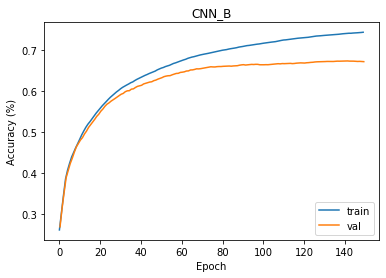

In [17]:
#Plotting training and validation accuracy vs epoch
trn_acc = [v['train'] for k, v in NetB_Acc.items()]
val_acc = [v['val'] for k, v in NetB_Acc.items()]

plt.title("CNN_B")
plt.plot(np.arange(len(trn_acc)), trn_acc,  label='train')
plt.plot(np.arange(len(val_acc))+ width, val_acc,  label='val')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.savefig('Graphs/CNN_B_Accuracy_150.png', bbox_inches='tight')
plt.show()

In [18]:
#Finding max validation accuracy and its epoch
NetB_max_val=0
NetB_max_val_epoch=0
tmp=0
for i in range(num_epochs):
    tmp=NetB_Acc[i+1]['val']
    if (tmp > NetB_max_val):
        NetB_max_val=tmp
        NetB_max_val_epoch=i+1
max_accuracy_comparison[1]=NetB_max_val
print('Max validation value for CNN_B is',NetB_max_val,'on epoch',NetB_max_val_epoch)

Max validation value for CNN_B is 0.6739 on epoch 142


### Problem 2: CIFAR 10 ResNet

#### Part A: ResNet-10

In [19]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [20]:
class ResNet10(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [21]:
#Running the model
ResNet10_Acc=collections.OrderedDict()
model = ResNet10(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = num_epochs,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader,
    acc_dict=ResNet10_Acc
)

all_acc_dict["ResNet10"] = validate(model, train_loader, val_loader, print_output=True)

0:00:32.143759 Epoch 1, Training loss 1.670492380657196
0:08:33.737146 Epoch 10, Training loss 0.8791415571689606
0:17:27.585585 Epoch 20, Training loss 0.6677674547481537
0:26:17.405881 Epoch 30, Training loss 0.5208570518517495
0:35:12.117588 Epoch 40, Training loss 0.3945508695077896
0:44:02.734101 Epoch 50, Training loss 0.29386621955126524
0:52:54.775038 Epoch 60, Training loss 0.24157326368659734
1:02:01.506646 Epoch 70, Training loss 0.2002396545922756
1:11:02.337852 Epoch 80, Training loss 0.1611895779967308
1:19:56.798897 Epoch 90, Training loss 0.1448541195956804
1:29:34.442609 Epoch 100, Training loss 0.11253682225305588
1:39:28.626400 Epoch 110, Training loss 0.08961697806826327
1:49:20.187588 Epoch 120, Training loss 0.09074521819687914
1:59:02.393923 Epoch 130, Training loss 0.08231208207511342
2:08:57.646058 Epoch 140, Training loss 0.07025332252292661
2:19:01.868884 Epoch 150, Training loss 0.056008280340376075
Accuracy train: 0.91
Accuracy val: 0.62


In [22]:
#Model size/Complexity
param_count_dict["ResNet10"]=get_model_info(model)

ResNet10(
  0.076 M, 100.000% Params, 1.212 GMac, 100.000% MACs, 
  (conv1): Conv2d(0.001 M, 1.178% Params, 0.045 GMac, 3.709% MACs, 3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (resblocks): Sequential(
    0.009 M, 12.199% Params, 1.164 GMac, 96.025% MACs, 
    (0): ResBlock(
      0.009 M, 12.199% Params, 1.164 GMac, 96.025% MACs, 
      (conv): Conv2d(0.009 M, 12.115% Params, 1.156 GMac, 95.363% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(0.0 M, 0.084% Params, 0.008 GMac, 0.662% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      0.009 M, 12.199% Params, 1.164 GMac, 96.025% MACs, 
      (conv): Conv2d(0.009 M, 12.115% Params, 1.156 GMac, 95.363% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(0.0 M, 0.084% Params, 0.008 GMac, 0.662% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_runnin

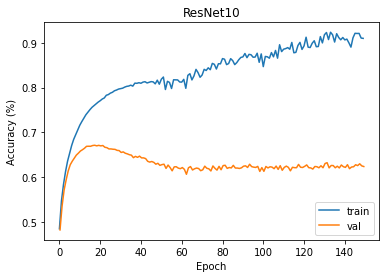

In [23]:
#Plotting training and validation accuracy vs epoch
trn_acc = [v['train'] for k, v in ResNet10_Acc.items()]
val_acc = [v['val'] for k, v in ResNet10_Acc.items()]

plt.title("ResNet10")
plt.plot(np.arange(len(trn_acc)), trn_acc,  label='train')
plt.plot(np.arange(len(val_acc))+ width, val_acc,  label='val')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.savefig('Graphs/ResNet10_Accuracy_150.png', bbox_inches='tight')
plt.show()

In [24]:
#Finding max validation accuracy and its epoch
ResNet10_max_val=0
ResNet10_max_val_epoch=0
tmp=0
for i in range(num_epochs):
    tmp=ResNet10_Acc[i+1]['val']
    if (tmp > ResNet10_max_val):
        ResNet10_max_val=tmp
        ResNet10_max_val_epoch=i+1
max_accuracy_comparison[2]=ResNet10_max_val
print('Max validation value for ResNet10 is',ResNet10_max_val,'on epoch',ResNet10_max_val_epoch)

Max validation value for ResNet10 is 0.6711 on epoch 18


#### Part B: Weight Decay w/ lambda of 0.001

In [27]:
#Defining the model
def weight_decay(n_epochs, optimizer, model, loss_fn, train_loader,acc_dict):
    start_time=datetime.datetime.now()
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())  
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now()-start_time, epoch,
                loss_train / len(train_loader)))
        acc_dict[epoch]=validate(model, train_loader, val_loader)

In [28]:
#Running the model
Weight_Decay_Acc=collections.OrderedDict()
model = ResNet10(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

weight_decay(
    n_epochs = 30,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    acc_dict=Weight_Decay_Acc
)
all_acc_dict["Weight_Decay"] = validate(model, train_loader, val_loader, print_output=True)

0:00:37.323456 Epoch 1, Training loss 1.7978973439598083
0:09:29.680783 Epoch 10, Training loss 0.975541273021698
0:19:27.327193 Epoch 20, Training loss 0.7716907100486755
0:29:18.630792 Epoch 30, Training loss 0.6332959752321243
Accuracy train: 0.80
Accuracy val: 0.67


In [29]:
#Model size/Complexity
param_count_dict["Weight_Decay"]=get_model_info(model)

ResNet10(
  0.076 M, 100.000% Params, 1.212 GMac, 100.000% MACs, 
  (conv1): Conv2d(0.001 M, 1.178% Params, 0.045 GMac, 3.709% MACs, 3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (resblocks): Sequential(
    0.009 M, 12.199% Params, 1.164 GMac, 96.025% MACs, 
    (0): ResBlock(
      0.009 M, 12.199% Params, 1.164 GMac, 96.025% MACs, 
      (conv): Conv2d(0.009 M, 12.115% Params, 1.156 GMac, 95.363% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(0.0 M, 0.084% Params, 0.008 GMac, 0.662% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      0.009 M, 12.199% Params, 1.164 GMac, 96.025% MACs, 
      (conv): Conv2d(0.009 M, 12.115% Params, 1.156 GMac, 95.363% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(0.0 M, 0.084% Params, 0.008 GMac, 0.662% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_runnin

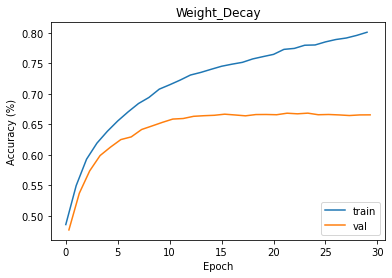

In [30]:
#Plotting training and validation accuracy vs epoch
trn_acc = [v['train'] for k, v in Weight_Decay_Acc.items()]
val_acc = [v['val'] for k, v in Weight_Decay_Acc.items()]

plt.title("Weight_Decay")
plt.plot(np.arange(len(trn_acc)), trn_acc,  label='train')
plt.plot(np.arange(len(val_acc))+ width, val_acc,  label='val')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.savefig('Graphs/Weight_Decay_Accuracy_30.png', bbox_inches='tight')
plt.show()

In [32]:
#Finding max validation accuracy and its epoch
Weight_Decay_max_val=0
Weight_Decay_max_val_epoch=0
tmp=0
for i in range(30):
    tmp=Weight_Decay_Acc[i+1]['val']
    if (tmp > Weight_Decay_max_val):
        Weight_Decay_max_val=tmp
        Weight_Decay_max_val_epoch=i+1
max_accuracy_comparison[3]=Weight_Decay_max_val
print('Max validation value for Weight_Decay is',Weight_Decay_max_val,'on epoch',Weight_Decay_max_val_epoch)

Max validation value for Weight_Decay is 0.6683 on epoch 24


#### Part B: Dropout w/ p=0.3

In [33]:
#Defining the model
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.3)
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [34]:
#Running the model
Dropout_Acc=collections.OrderedDict()
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 50,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
        val_loader = val_loader,
    acc_dict=Dropout_Acc
)
all_acc_dict["Dropout"] = validate(model, train_loader, val_loader, print_output=True)

0:00:32.739781 Epoch 1, Training loss 1.871734328994751
0:08:45.886135 Epoch 10, Training loss 1.108644901447296
0:17:53.568625 Epoch 20, Training loss 0.9347454721927643
0:27:01.428297 Epoch 30, Training loss 0.829053165512085
0:36:03.897273 Epoch 40, Training loss 0.7503068481397629
0:45:02.198260 Epoch 50, Training loss 0.6883086155486107
Accuracy train: 0.75
Accuracy val: 0.65


In [35]:
#Model size/Complexity
param_count_dict["Dropout"]=get_model_info(model)

NetDropout(
  0.076 M, 100.000% Params, 1.212 GMac, 100.000% MACs, 
  (conv1): Conv2d(0.001 M, 1.178% Params, 0.045 GMac, 3.709% MACs, 3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_dropout): Dropout2d(0.0 M, 0.000% Params, 0.0 GMac, 0.000% MACs, p=0.3, inplace=False)
  (resblocks): Sequential(
    0.009 M, 12.199% Params, 1.164 GMac, 96.025% MACs, 
    (0): ResBlock(
      0.009 M, 12.199% Params, 1.164 GMac, 96.025% MACs, 
      (conv): Conv2d(0.009 M, 12.115% Params, 1.156 GMac, 95.363% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(0.0 M, 0.084% Params, 0.008 GMac, 0.662% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      0.009 M, 12.199% Params, 1.164 GMac, 96.025% MACs, 
      (conv): Conv2d(0.009 M, 12.115% Params, 1.156 GMac, 95.363% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(0.0

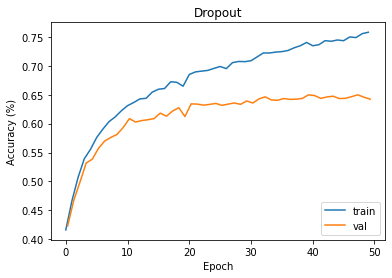

In [36]:
#Plotting training and validation accuracy vs epoch
trn_acc = [v['train'] for k, v in Dropout_Acc.items()]
val_acc = [v['val'] for k, v in Dropout_Acc.items()]

plt.title("Dropout")
plt.plot(np.arange(len(trn_acc)), trn_acc,  label='train')
plt.plot(np.arange(len(val_acc))+ width, val_acc,  label='val')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.savefig('Graphs/Dropout_Accuracy_50.png', bbox_inches='tight')
plt.show()

In [37]:
#Finding max validation accuracy and its epoch
Dropout_max_val=0
Dropout_max_val_epoch=0
tmp=0
for i in range(50):
    tmp=Dropout_Acc[i+1]['val']
    if (tmp > Dropout_max_val):
        Dropout_max_val=tmp
        Dropout_max_val_epoch=i+1
max_accuracy_comparison[4]=Dropout_max_val
print('Max validation value for Dropout is',Dropout_max_val,'on epoch',Dropout_max_val_epoch)

Max validation value for Dropout is 0.6498 on epoch 48


#### Part B: Batch Normalization

In [38]:
#Defining the model
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        out = F.max_pool2d(x, 2)
        #out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        #out = self.conv1_batchnorm(self.conv1(x))
        out = self.conv1_batchnorm(self.conv1(out))
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [39]:
#Running the model
Batch_norm_Acc=collections.OrderedDict()
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 20,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader,
    acc_dict=Batch_norm_Acc
)
all_acc_dict["Batch_norm"] = validate(model, train_loader, val_loader, print_output=True)

0:00:32.587660 Epoch 1, Training loss 1.6605897638511657
0:08:49.617029 Epoch 10, Training loss 0.9486640095233917
0:17:59.217177 Epoch 20, Training loss 0.7515977625226975
Accuracy train: 0.73
Accuracy val: 0.60


In [40]:
#Model size/Complexity
param_count_dict["Batch_norm"]=get_model_info(model)

NetBatchNorm(
  0.076 M, 100.000% Params, 1.179 GMac, 100.000% MACs, 
  (conv1): Conv2d(0.001 M, 1.177% Params, 0.011 GMac, 0.953% MACs, 3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_batchnorm): BatchNorm2d(0.0 M, 0.084% Params, 0.001 GMac, 0.068% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (resblocks): Sequential(
    0.009 M, 12.188% Params, 1.164 GMac, 98.705% MACs, 
    (0): ResBlock(
      0.009 M, 12.188% Params, 1.164 GMac, 98.705% MACs, 
      (conv): Conv2d(0.009 M, 12.104% Params, 1.156 GMac, 98.025% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(0.0 M, 0.084% Params, 0.008 GMac, 0.681% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      0.009 M, 12.188% Params, 1.164 GMac, 98.705% MACs, 
      (conv): Conv2d(0.009 M, 12.104% Params, 1.156 GMac, 98.025% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(

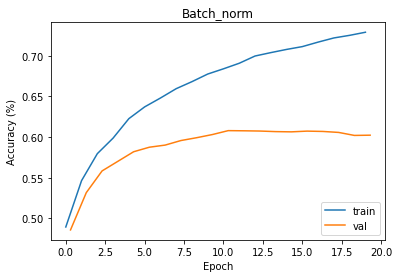

In [50]:
#Plotting training and validation accuracy vs epoch
trn_acc = [v['train'] for k, v in Batch_norm_Acc.items()]
val_acc = [v['val'] for k, v in Batch_norm_Acc.items()]

plt.title("Batch_norm")
plt.plot(np.arange(len(trn_acc)), trn_acc,  label='train')
plt.plot(np.arange(len(val_acc))+ width, val_acc,  label='val')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.savefig('Graphs/Batch_Norm_Accuracy_20.png', bbox_inches='tight')
plt.show()

In [42]:
#Finding max validation accuracy and its epoch
Batch_norm_max_val=0
Batch_norm_max_val_epoch=0
tmp=0
for i in range(20):
    tmp=Batch_norm_Acc[i+1]['val']
    if (tmp > Batch_norm_max_val):
        Batch_norm_max_val=tmp
        Batch_norm_max_val_epoch=i+1
max_accuracy_comparison[5]=Batch_norm_max_val
print('Max validation value for Batch_norm is',Batch_norm_max_val,'on epoch',Batch_norm_max_val_epoch)

Max validation value for Batch_norm is 0.6079 on epoch 11


# Model Accuracy Comparisons

#### Max Validation and Training Accuracy

In [43]:
#Array of all max validation accuracy for each model
max_accuracy_comparison

array([0.6418, 0.6739, 0.6711, 0.6683, 0.6498, 0.6079])

In [44]:
#Final epoch values (for train values these are their max)
all_acc_dict

OrderedDict([('CNN_A', {'train': 0.69544, 'val': 0.6402}),
             ('CNN_B', {'train': 0.74396, 'val': 0.6722}),
             ('ResNet10', {'train': 0.9097, 'val': 0.6236}),
             ('Weight_Decay', {'train': 0.80084, 'val': 0.6655}),
             ('Dropout', {'train': 0.75436, 'val': 0.6451}),
             ('Batch_norm', {'train': 0.729, 'val': 0.6023})])

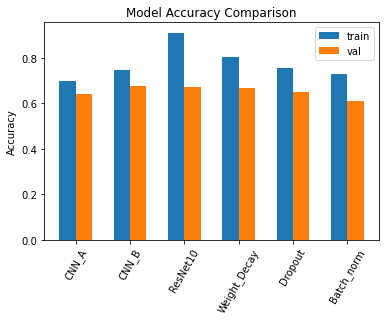

In [45]:
#Plotting max train & val accuracies
trn_acc = [v['train'] for k, v in all_acc_dict.items()] #from dict
val_acc=max_accuracy_comparison #from array

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(trn_acc))+ width/2, list(all_acc_dict.keys()), rotation=60)
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
#plt.ylim(0.6, 0.75)
plt.title("Model Accuracy Comparison")
plt.savefig('Graphs/accuracy_comparison.png', bbox_inches='tight')
plt.show()


#### Model Parameter Comparision

In [46]:
#Dictionary holds all models complexity and size
param_count_dict

OrderedDict([('CNN_A', {'Params': '16.97 k', 'macs': '0.01 GMac'}),
             ('CNN_B', {'Params': '18.35 k', 'macs': '0.04 GMac'}),
             ('ResNet10', {'Params': '76.07 k', 'macs': '1.21 GMac'}),
             ('Weight_Decay', {'Params': '76.07 k', 'macs': '1.21 GMac'}),
             ('Dropout', {'Params': '76.07 k', 'macs': '1.21 GMac'}),
             ('Batch_norm', {'Params': '76.14 k', 'macs': '1.18 GMac'})])

In [47]:
#Dict holds strings for Macs and params, manually transfer to arrays for plotting
mac_count=np.array([0.01,0.04,1.21,1.21,1.21,1.18])
param_count=np.array([16.97,18.35,76.07,76.07,76.07,76.14])

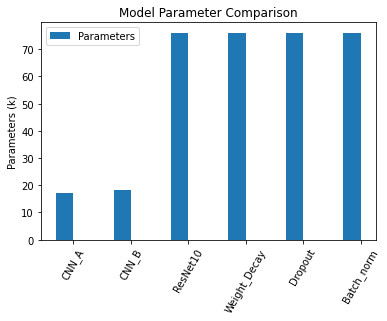

In [48]:
#Plot all model parameter counts
width =0.3
plt.bar(np.arange(len(param_count)), param_count, width=width, label='Parameters')
plt.xticks(np.arange(len(param_count))+ width/2, list(all_acc_dict.keys()), rotation=60)
plt.ylabel('Parameters (k)')
plt.legend(loc='upper left')
plt.title("Model Parameter Comparison")
plt.savefig('Graphs/Parameter_comparison.png', bbox_inches='tight')
plt.show()

#### Model GMac Comparison

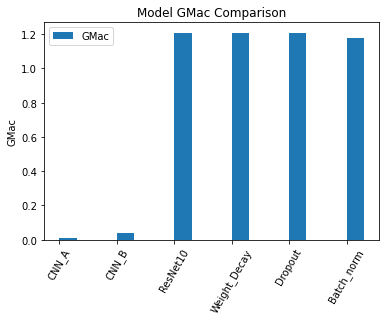

In [49]:
#Plot all model GMac counts
width =0.3
plt.bar(np.arange(len(mac_count))+ width, mac_count, width=width, label='GMac')
plt.xticks(np.arange(len(mac_count))+ width/2, list(all_acc_dict.keys()), rotation=60)
plt.ylabel('GMac')
plt.legend(loc='upper left')
plt.title("Model GMac Comparison")
plt.savefig('Graphs/GMac_comparison.png', bbox_inches='tight')
plt.show()